# Variational Auto-Encoder

Auto-encoder is a type of neural network that can learn a compact representation (encoding) of a dataset. 

Auto-encoders can be used for several purpose, including:
- Dimensionality reduction, for the purpose of plotting, or to make further computations easier.
- Data generation: create new data points resembling instances of the training set

VAE uses a variational bayesian approach, i.e. it makes assumption about the distribution of the encoding and uses probability theory and statistical tools to train the encoder and decoders.

We'll use VAE to cluster and classify instances of the [Epileptic Seizure Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition).

Data points have 178 dimensions, so we'll use VAE to come up with a more compact representation, perhaps in as few as 2 or 3 dimensions. We will then apply clustering and classification (seizure vs no seizure) techniques before and after the dimensionality reduction, and see what works best.

Resources:
- [VAE original paper](https://arxiv.org/pdf/1312.6114.pdf)
- [Good explanations of some of the maths in the paper](https://blog.evjang.com/2016/08/variational-bayes.html)
- [Implementing VAE with Tensorflow](https://danijar.com/building-variational-auto-encoders-in-tensorflow/)

In [35]:
import collections

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection
import sklearn.preprocessing
import tensorflow as tf

from vae_model import VariationalAutoEncoder

sns.set(font_scale=1.5, palette='colorblind')

## Data

In [2]:
dataset = pd.read_csv("data/epileptic_seizure_dataset.csv")

In [3]:
for i in range(0, 178):
    dataset[f'X{i+1}'] = dataset[f'X{i+1}'].astype(np.float32)

dataset.head()

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135.0,190.0,229.0,223.0,192.0,125.0,55.0,-9.0,-33.0,...,-17.0,-15.0,-31.0,-77.0,-103.0,-127.0,-116.0,-83.0,-51.0,4
1,X15.V1.924,386.0,382.0,356.0,331.0,320.0,315.0,307.0,272.0,244.0,...,164.0,150.0,146.0,152.0,157.0,156.0,154.0,143.0,129.0,1
2,X8.V1.1,-32.0,-39.0,-47.0,-37.0,-32.0,-36.0,-57.0,-73.0,-85.0,...,57.0,64.0,48.0,19.0,-12.0,-30.0,-35.0,-35.0,-36.0,5
3,X16.V1.60,-105.0,-101.0,-96.0,-92.0,-89.0,-95.0,-102.0,-100.0,-87.0,...,-82.0,-81.0,-80.0,-77.0,-85.0,-77.0,-72.0,-69.0,-65.0,5
4,X20.V1.54,-9.0,-65.0,-98.0,-102.0,-78.0,-48.0,-16.0,0.0,-21.0,...,4.0,2.0,-12.0,-32.0,-41.0,-65.0,-83.0,-89.0,-73.0,5


In [4]:
X = dataset[dataset.columns[1:-1]].values
y = dataset['y']

scaler = sklearn.preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_norm, y, test_size=0.2, random_state=444)

## Dimensionality reduction (from 178 to 3)

In [5]:
vae_cls = VariationalAutoEncoder(178, 3)

In [6]:
def random_draw(x, y=None, batch_size=100):
    indices = np.random.randint(0, len(x), batch_size)
    if y is not None:
        return x[indices], y[indices]
    else:
        return x[indices]

def train_vae(vae_cls, x, x_test, learning_rate, n_epochs, batch_size, name='vae'):
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        
        for i, epoch in enumerate(range(n_epochs)):            
            x_batch = random_draw(x, batch_size=batch_size)

            sess.run(
                vae_cls.train_op, 
                feed_dict={
                    vae_cls.x: x_batch, 
                    vae_cls.learning_rate: learning_rate,
                },
            )
            
            if i % 1000 == 0:
                elbo_test = sess.run(vae_cls.elbo_loss, feed_dict={vae_cls.x: x_test})
                print(f'Iteration {i} / {n_epochs}: elbo test set = {elbo_test}')
        
        return saver.save(sess, f'./{name}_{learning_rate}.ckpt')

In [7]:
save_path = train_vae(vae_cls, X_train, X_test, 0.001, 2000, 100)

Iteration 0 / 2000: elbo test set = -816.5985717773438
Iteration 1000 / 2000: elbo test set = -101.9408187866211


In [8]:
def sample(vae_cls, num_samples, save_path):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        return sess.run(vae_cls.samples, {vae_cls.num_samples: num_samples})

In [9]:
X_sample_n = sample(vae_cls, 10, save_path)

INFO:tensorflow:Restoring parameters from ./vae_0.001.ckpt


In [10]:
X_sample_n.shape

(10, 178)

In [11]:
X_sample = scaler.inverse_transform(X_sample_n)

In [12]:
def plot_data(data):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    instance = data[0]
    x = range(len(instance))
    
    for instance in data:
        ax.plot(x, instance, '-')

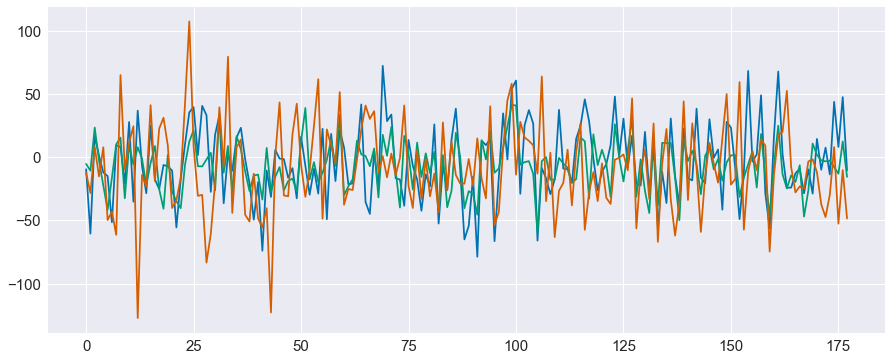

In [13]:
plot_data(X_sample[:3])

In [14]:
def encoding(vae_cls, x, save_path):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        return sess.run(vae_cls.encoding, {vae_cls.x: x})

In [15]:
X_code = encoding(vae_cls, X_train, save_path)

INFO:tensorflow:Restoring parameters from ./vae_0.001.ckpt


In [38]:
def plot_encoding(X_code, y):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    vals = np.unique(y)
    
    data_per_class = collections.defaultdict(list)
    for i, v in enumerate(y):
        x_c = X_code[i]
        cls = 'Seizure' if v == 1 else 'No seizure'
        data_per_class[cls].append(x_c)
    
    for v in sorted(data_per_class.keys()):
        data = data_per_class[v]
        x1 = [i for i, _, _ in data]
        x2 = [j for _, j, _ in data]
        x3 = [k for _, _, k in data]
        ax.scatter(x1, x2, x3, label=v)
        
    ax.legend()

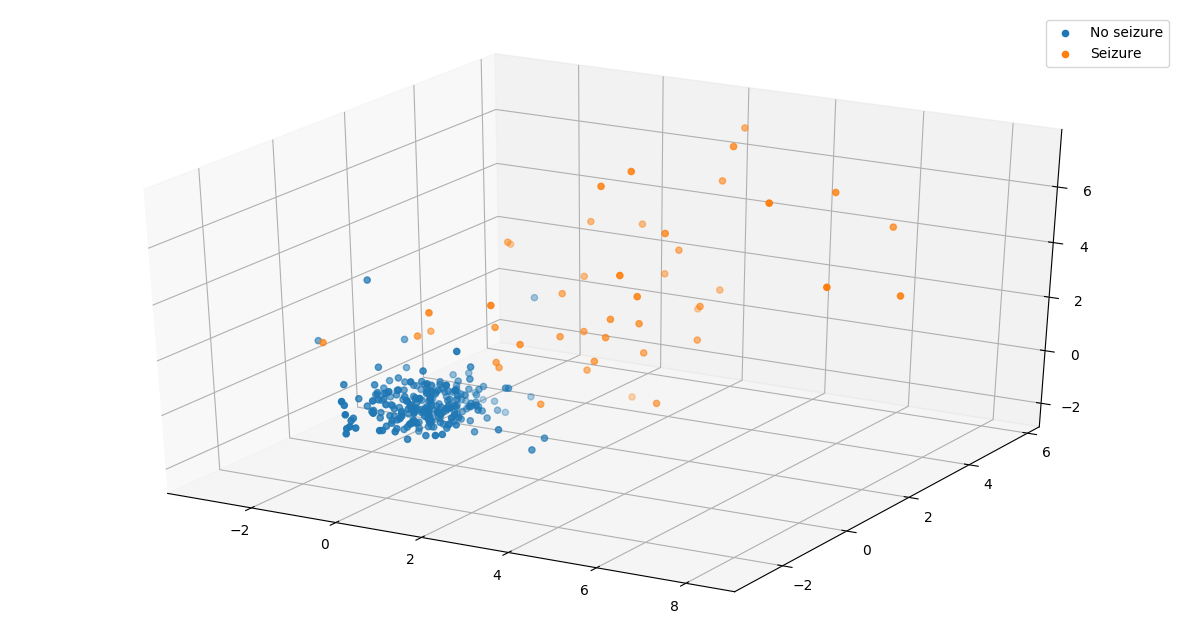

In [39]:
sns.reset_orig()
n = 300
plot_encoding(X_code[:n], y_train[:n])